<h1>Dynamic Community Detection</h1>

In [8]:
import io
import uuid
from xml.etree import ElementTree
import requests
import scipy.stats as st
from matplotlib import colors
import matplotlib
import numpy as np
import datetime
import csv
import matplotlib.gridspec as gridspec
from pathlib import Path
import statistics
from rdflib import Graph, ConjunctiveGraph, Namespace, OWL, Literal, URIRef, BNode, XSD, RDFS, RDF
from SPARQLWrapper import SPARQLWrapper, JSON
import networkx as nx
import networkx.algorithms.community as nx_comm
from cdlib import algorithms
import matplotlib.pyplot as plt
from cdlib import evaluation
from cdlib import TemporalClustering
from cdlib.algorithms import louvain
from cdlib import algorithms, viz
from src import hintohg
from src import dynamic_cd
from collections import Counter

<h1>Defining meta-paths</h1>

In [2]:
# Illustrator - Book - Illustrator
BIB = """PREFIX sem: <http://semanticweb.cs.vu.nl/2009/11/sem/>
        PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#> 
        PREFIX schema: <https://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        SELECT * WHERE {
                GRAPH <https://data.goldenagents.org/datasets/u692bc364e9d7fa97b3510c6c0c8f2bb9a0e5123b/processes_of_creativity_20220128> {
                        
                        ?b schema:illustrator ?w1, ?w2 ;
                                schema:publication ?publicationEvent .
                        
                        # Iets expliciet maken helpt altijd voor de query-processor.
                        ?publicationEvent a schema:PublicationEvent .
                        
                        OPTIONAL { ?publicationEvent sem:hasEarliestBeginTimeStamp ?bt}. 
                        OPTIONAL { ?publicationEvent sem:hasLatestEndTimeStamp ?et}.
                        
                        FILTER(?w1 != ?w2).
                        # FILTER(?w1 < ?w2) # RDF kent geen volgorde 
                }
        }"""

# Contributor - Book - Contributor
BCB = """PREFIX sem: <http://semanticweb.cs.vu.nl/2009/11/sem/>
        PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#> 
        PREFIX schema: <https://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        SELECT * WHERE {
                GRAPH <https://data.goldenagents.org/datasets/u692bc364e9d7fa97b3510c6c0c8f2bb9a0e5123b/processes_of_creativity_20220128> {
                        
                        ?b schema:contributor ?w1, ?w2 ;
                                schema:publication ?publicationEvent .
                        
                        # Iets expliciet maken helpt altijd voor de query-processor.
                        ?publicationEvent a schema:PublicationEvent .
                        
                        OPTIONAL { ?publicationEvent sem:hasEarliestBeginTimeStamp ?bt}. 
                        OPTIONAL { ?publicationEvent sem:hasLatestEndTimeStamp ?et}.
                        
                        FILTER(?w1 != ?w2).
                        # FILTER(?w1 < ?w2) # RDF kent geen volgorde 
                }
        }"""
BCPIB = """PREFIX sem: <http://semanticweb.cs.vu.nl/2009/11/sem/>
                PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#> 
                PREFIX schema: <https://schema.org/>
                PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
                PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
                SELECT * WHERE {
                
                ?b schema:illustrator|schema:contributor|schema:publication/schema:publishedBy ?w1, ?w2 ;
                        schema:publication ?publicationEvent .
                
                # Iets expliciet maken helpt altijd voor de query-processor.
                ?publicationEvent a schema:PublicationEvent .
                
                OPTIONAL { ?publicationEvent sem:hasEarliestBeginTimeStamp ?bt}. # Typo in de STCN
                OPTIONAL { ?publicationEvent sem:hasLatestEndTimeStamp ?et}.
                # OPTIONAL { ?bt a ?type}.  # Typo in de STCN
                
                FILTER(?w1 != ?w2).
                # FILTER(xsd:integer(?bt) < 1800).
                # FILTER(?w1 < ?w2)  # RDF kent geen volgorde 
}"""

metapaths = { "BIB" : BIB,
              "BCB" : BCB,
              "BCPIB" : BCPIB
            }

<h1>Creating the homogeneous graph</h1>

<p>Here, we create a homogeneous graph for one of the metapaths (if one hasn't already been created. If it is, it is stored in cache and retrieved). Change the variable named "selected_mp" to change the meta-path that is used for this. The variable can have the following values:</p>

<ul>
    <li>BIB</li>
    <li>BCB</li>
</ul>

HG imported


(-0.30248547847845647,
 0.3714209239040305,
 -0.29791491138511583,
 0.3035601838919817)

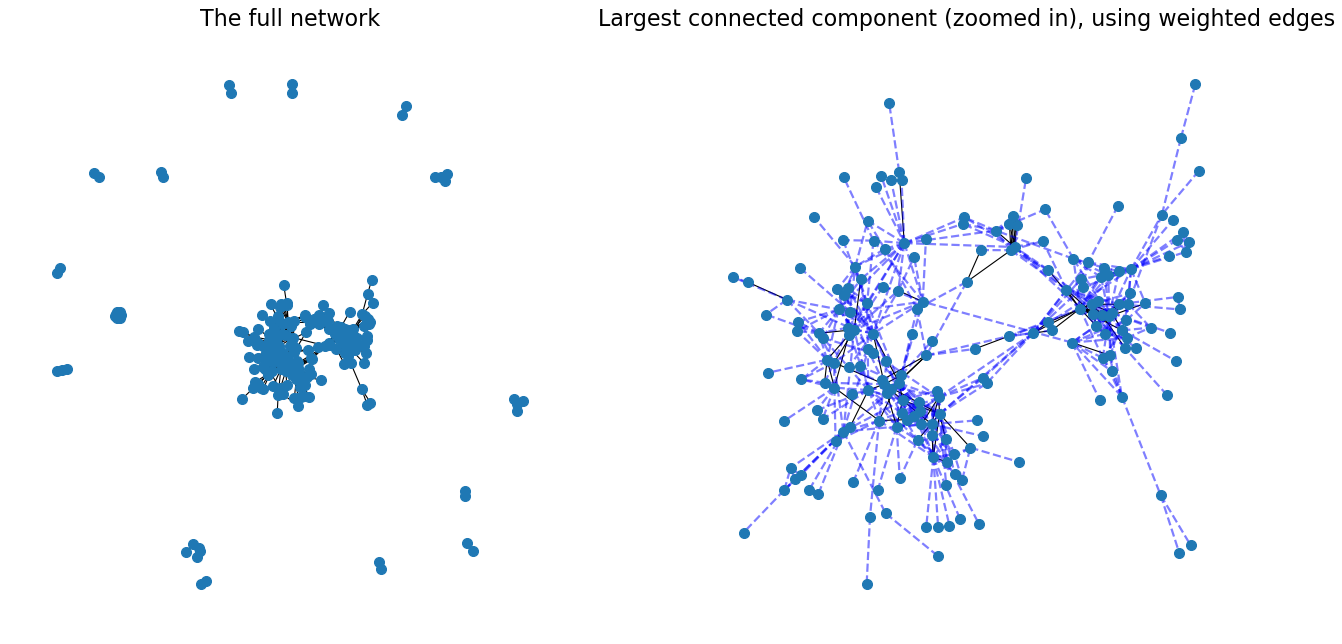

In [3]:

# YOU CAN EDIT THIS TO CHANGE THE USED META-PATH
selected_mp = "BIB"

# Check if the homogeneous graph is present in cache
# If not, create it
data_folder = Path("./homogeneous_graphs/") 
file_to_check = data_folder / (selected_mp + ".gpickle")

if not file_to_check.exists():
    query = metapaths[selected_mp]
    hg = hintohg.rdf_to_homogeneous_endpoint(query)
    nx.write_gpickle(hg, data_folder / (selected_mp + ".gpickle"))
    print("HG saved in folder \"homogeneous_graphs\"")
else:
    hg = nx.read_gpickle(data_folder / (selected_mp + ".gpickle")) 
    print("HG imported")


# Get the largest component of the graph
components = nx.connected_components(hg)
largest_component_size = max(components, key=len)
hg_lcc = hg.subgraph(largest_component_size)

# Draw the network
from matplotlib.pyplot import figure
pos = nx.spring_layout(hg, seed=7)  # positions for all nodes - seed for reproducibility
figure(figsize=(20, 10), dpi=80)

subax1 = plt.subplot(121)
plt.title("The full network", fontsize=20)
nx.draw(hg, pos, node_size = 80, with_labels=False)
subax2 = plt.subplot(122)

plt.title("Largest connected component (zoomed in), using weighted edges", fontsize=20)
# Draw the nodes and the weighted edges
elarge = [(u, v) for (u, v, d) in hg_lcc.edges(data=True) if d["weight"] > 2]
esmall = [(u, v) for (u, v, d) in hg_lcc.edges(data=True) if d["weight"] <= 2]
nx.draw_networkx_nodes(hg_lcc, pos, node_size=80)
nx.draw_networkx_edges(hg_lcc, pos, edgelist=elarge, width=1)
nx.draw_networkx_edges(
    hg_lcc, pos, edgelist=esmall, width=2, alpha=0.5, edge_color="b", style="dashed"
)
plt.axis("off")
# nx.draw(hg_lcc, node_size = 80, with_labels=False)


<h1>Creating the snaphsot graph(s) and performing dynamic community detection (dcd)</h1>

<p>Here, the snapshot graphs will be created and dcd will be performed, using a time interval and a shift. These values may be changed.<p>

In [4]:
interval = 20
shift = 10

snapshot_graph = dynamic_cd.create_snapshot_graph(hg, interval, shift)
theta = 0.3
(dcd_results_init_partition, tc, snapshots, snapshot_times) = dynamic_cd.execute_dcd(snapshot_graph, f"{interval}_{shift}")
dynamic_coms = dynamic_cd.matching(tc, theta)

Interval: 20, Stepsize: 10
Num of snapshots: 27
Handling sg with parameters: 20_10
MERGING [6, 7]
MERGING [6, 7]
MERGING [23, 26]
MERGING [23, 26]
MERGING [38, 44]
MERGING [38, 44]
MERGING [13, 49]
MERGING [13, 49]
MERGING [64, 66]
MERGING [43, 58]


<h1>Find all dynamic communities a person belongs to and print the dynamic communities in chronological order</h1>

<p>You can change the "name" variable below</p>

NAME TO FIND: Theodoor Matham
7_1
8_2
9_2
10_4
11_0
12_0
TIMESTEP: 7
DYNAMIC COMMUNITY: 9
INTERVAL (1607, 1627)


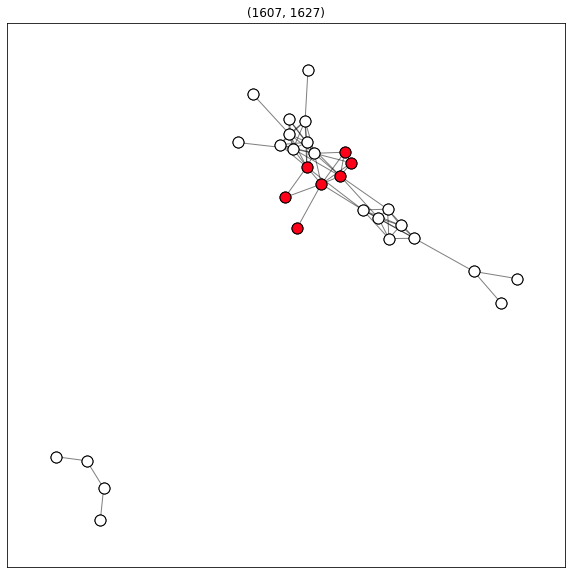

Theodoor Matham - Centrality: 0.31 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/4892
Willem (van) de Passe - Centrality: 0.276 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/5896
Jan Gerritsz. Sweelinck - Centrality: 0.276 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/7266
Johannes Gelle - Centrality: 0.138 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/3136
Christiaan le Blon - Centrality: 0.138 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/4508
Gillis van Schendel - Centrality: 0.069 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/6637
Hubert Goltzius - Centrality: 0.034 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/3274
-------------------------------------------------------------
TIMESTEP: 8
DYNAMIC COMMUNITY: 10
INTERVAL (1617, 1637)


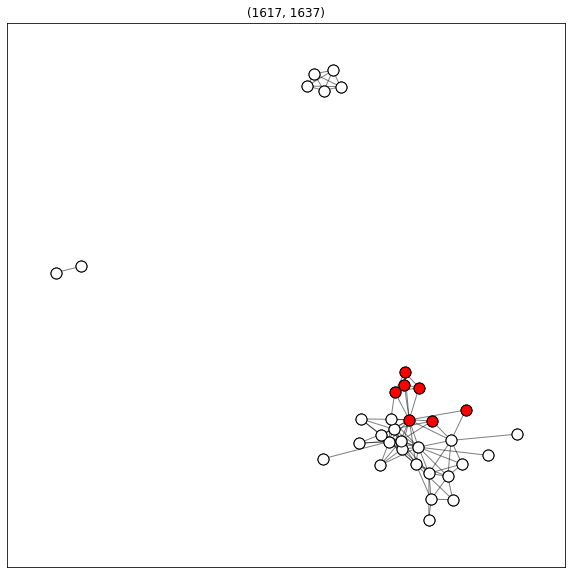

Theodoor Matham - Centrality: 0.471 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/4892
Jan Jansz van den Velde I - Centrality: 0.147 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/7628
Willem Outgertsz Akersloot - Centrality: 0.118 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/522
Pieter Jansz. Saenredam - Centrality: 0.118 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/6517
Jacob van Campen - Centrality: 0.118 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/1616
Gillis van Schendel - Centrality: 0.118 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/6637
Simon (van) de(r) Passe - Centrality: 0.059 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/5895
-------------------------------------------------------------
TIMESTEP: 9
DYNAMIC COMMUNITY: 10
INTERVAL (1627, 1647)


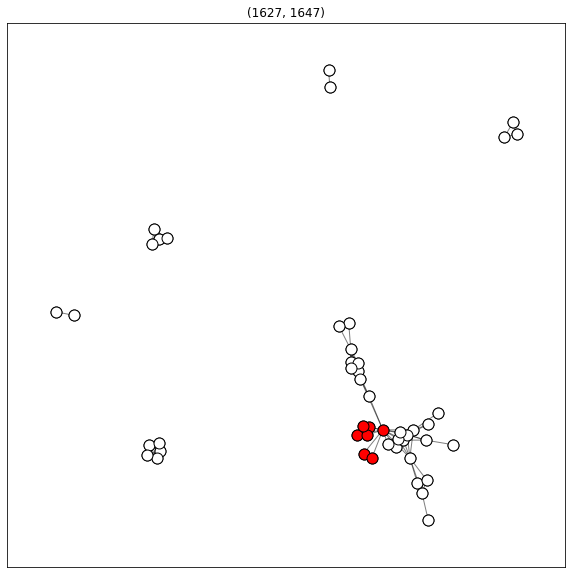

Theodoor Matham - Centrality: 0.34 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/4892
Willem Outgertsz Akersloot - Centrality: 0.085 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/522
Pieter Jansz. Saenredam - Centrality: 0.085 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/6517
Jan Jansz van den Velde I - Centrality: 0.085 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/7628
Jacob van Campen - Centrality: 0.085 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/1616
Simon (van) de(r) Passe - Centrality: 0.043 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/5895
Jan Gerritsz. Sweelinck - Centrality: 0.043 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/7266
-------------------------------------------------------------
TIMESTEP: 10
DYNAMIC COMMUNITY: 19
INTERVAL (1637, 1657)


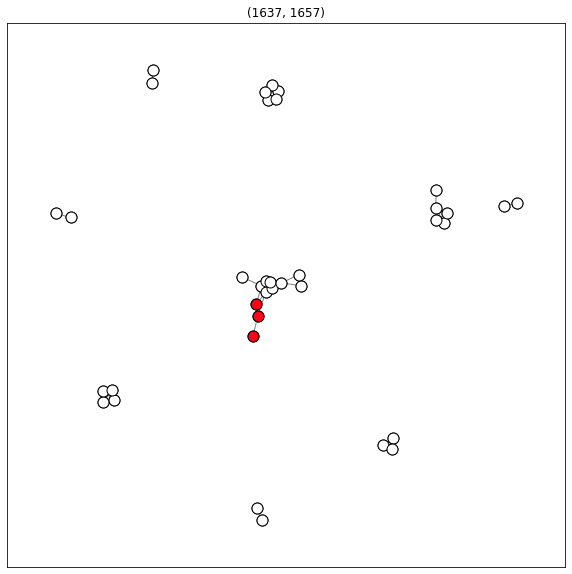

Theodoor Matham - Centrality: 0.083 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/4892
Joachim (van) Sandrart - Centrality: 0.083 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/6555
Steven van Lamsweerde - Centrality: 0.028 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/4458
-------------------------------------------------------------
TIMESTEP: 11
DYNAMIC COMMUNITY: 19
INTERVAL (1647, 1667)


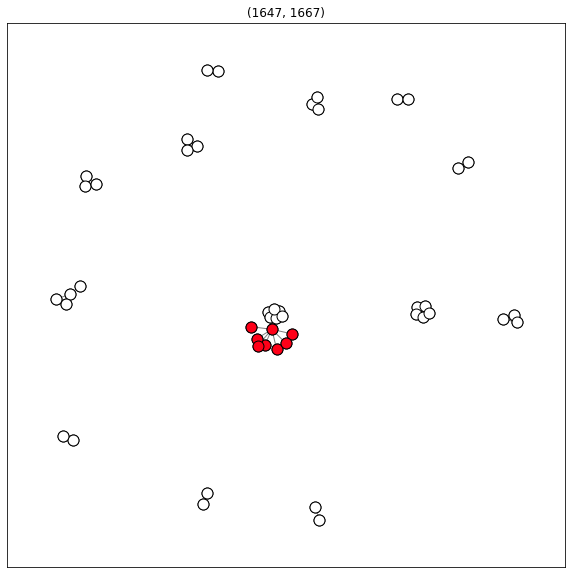

Theodoor Matham - Centrality: 0.283 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/4892
Pieter Serwouters - Centrality: 0.065 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/6794
Gillis van Schendel - Centrality: 0.065 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/6637
Adriaen Jacobsen Matham - Centrality: 0.065 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/4889
Steven van Lamsweerde - Centrality: 0.022 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/4458
Salomon Savery - Centrality: 0.022 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/6583
Joachim (van) Sandrart - Centrality: 0.022 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/6555
Adriaen Pietersz van de Venne - Centrality: 0.022 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/7653
-------------------------------------------------------------
TIMESTEP: 12
DYNAMIC COMMUNITY: 21
INTERVAL (1657, 1677)


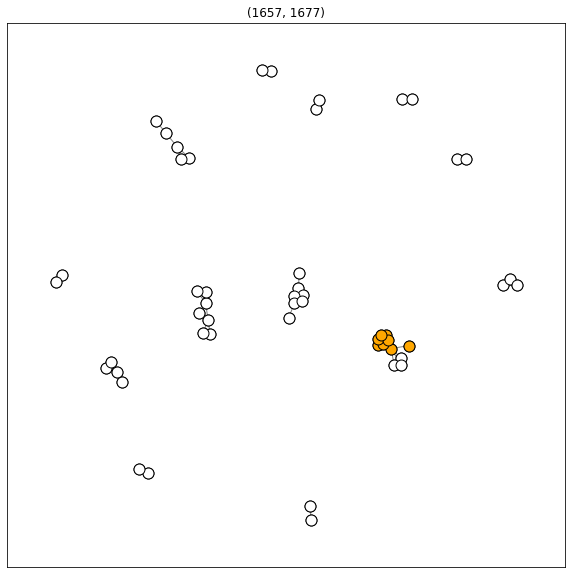

Theodoor Matham - Centrality: 0.2 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/4892
Jeremias Falck - Centrality: 0.12 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/2863
Janus Lutma II - Centrality: 0.12 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/4759
Jacob Adriaansz Matham - Centrality: 0.12 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/4890
Cornelis van Dalen II - Centrality: 0.12 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/2321
Cornelis Pietersz. Holsteyn - Centrality: 0.12 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/3789
Cornelis (de) Visscher (II) - Centrality: 0.12 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/7902
Adriaen Pietersz van de Venne - Centrality: 0.02 - URI:https://www.vondel.humanities.uva.nl/ecartico/persons/7653
-------------------------------------------------------------


In [5]:
# EDIT THIS
name = "Theodoor Matham"

res = dynamic_cd.find_dyn_com(dynamic_coms, name, tc, snapshots, snapshot_times)

<h1>Analyse dynamic community based on ID</h1>

<p>Change the "dynamic_com_id" variable below to print the evolution of that community</p>

(1647, 1667)


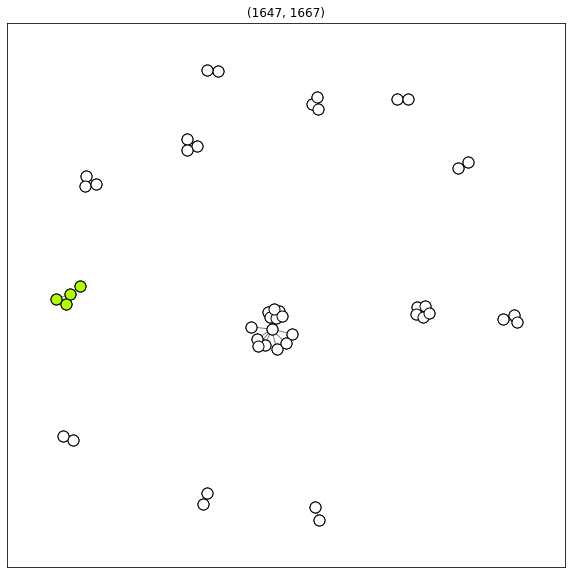

Jan Jansz. Veenhuysen - Centrality: 0.065 - URI: https://www.vondel.humanities.uva.nl/ecartico/persons/7602
Zacharias Webber - Centrality: 0.043 - URI: https://www.vondel.humanities.uva.nl/ecartico/persons/8177
Abraham Blooteling - Centrality: 0.043 - URI: https://www.vondel.humanities.uva.nl/ecartico/persons/1061
Jacob Willems van Meurs - Centrality: 0.022 - URI: https://www.vondel.humanities.uva.nl/ecartico/persons/5223
-------------------------
(1657, 1677)


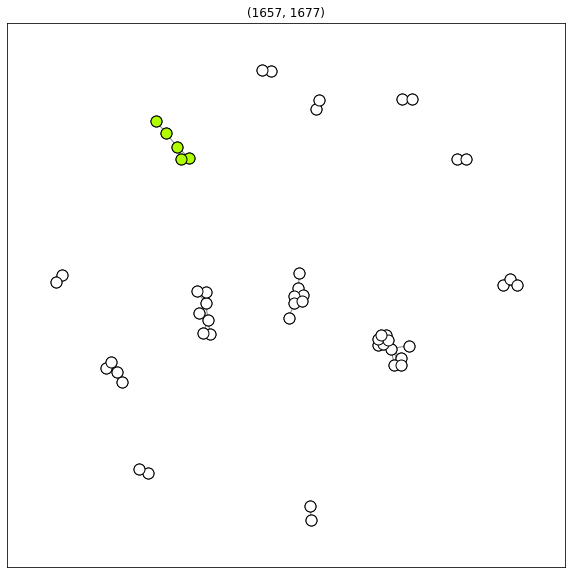

Jan Jansz. Veenhuysen - Centrality: 0.06 - URI: https://www.vondel.humanities.uva.nl/ecartico/persons/7602
Zacharias Webber - Centrality: 0.04 - URI: https://www.vondel.humanities.uva.nl/ecartico/persons/8177
Jacob Willems van Meurs - Centrality: 0.04 - URI: https://www.vondel.humanities.uva.nl/ecartico/persons/5223
Abraham Blooteling - Centrality: 0.04 - URI: https://www.vondel.humanities.uva.nl/ecartico/persons/1061
Arnoldus Montanus - Centrality: 0.02 - URI: https://www.vondel.humanities.uva.nl/ecartico/persons/53229
-------------------------
(1667, 1687)


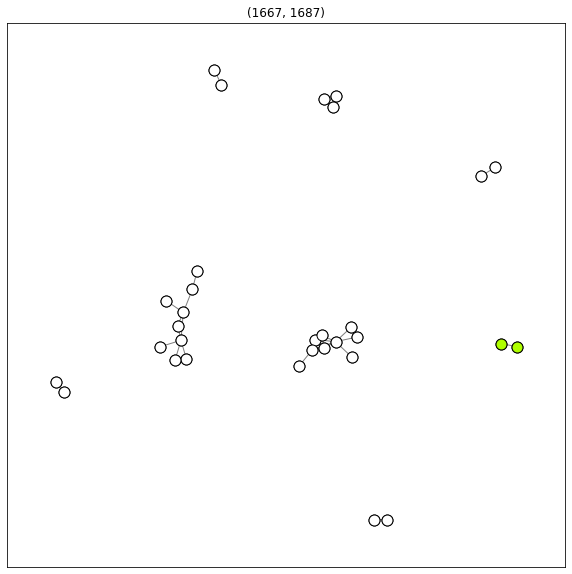

Jacob Willems van Meurs - Centrality: 0.033 - URI: https://www.vondel.humanities.uva.nl/ecartico/persons/5223
Arnoldus Montanus - Centrality: 0.033 - URI: https://www.vondel.humanities.uva.nl/ecartico/persons/53229
-------------------------


In [6]:
#EDIT THIS
dynamic_com_id = 22

res = dynamic_cd.print_dyn_com(dynamic_coms, dynamic_com_id, tc, snapshots, snapshot_times)

<h1>Find descriptions of dynamic communities, based on birthplace and religion (will be extended)</h1>

<p>Change the "dynamic_com_id" variable below to print the description of that dynamic community</p>


In [7]:
# EDIT THIS
dynamic_com_id = 26

union_com = dynamic_cd.get_community_union(tc, snapshots, snapshot_times, dynamic_coms, dynamic_com_id)
dynamic_cd.get_community_description(union_com)

([('Amsterdam', 8)], [('Roman Catholic', 7)])